
📥 STEP 1 & 2: DATA PREPARATION
Shape: (2484, 4)
Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']

Encoded Labels: {'ACCOUNTANT': np.int64(0), 'ADVOCATE': np.int64(1), 'AGRICULTURE': np.int64(2), 'APPAREL': np.int64(3), 'ARTS': np.int64(4), 'AUTOMOBILE': np.int64(5), 'AVIATION': np.int64(6), 'BANKING': np.int64(7), 'BPO': np.int64(8), 'BUSINESS-DEVELOPMENT': np.int64(9), 'CHEF': np.int64(10), 'CONSTRUCTION': np.int64(11), 'CONSULTANT': np.int64(12), 'DESIGNER': np.int64(13), 'DIGITAL-MEDIA': np.int64(14), 'ENGINEERING': np.int64(15), 'FINANCE': np.int64(16), 'FITNESS': np.int64(17), 'HEALTHCARE': np.int64(18), 'HR': np.int64(19), 'INFORMATION-TECHNOLOGY': np.int64(20), 'PUBLIC-RELATIONS': np.int64(21), 'SALES': np.int64(22), 'TEACHER': np.int64(23)}

📊 STEP 3: DATA VISUALIZATION


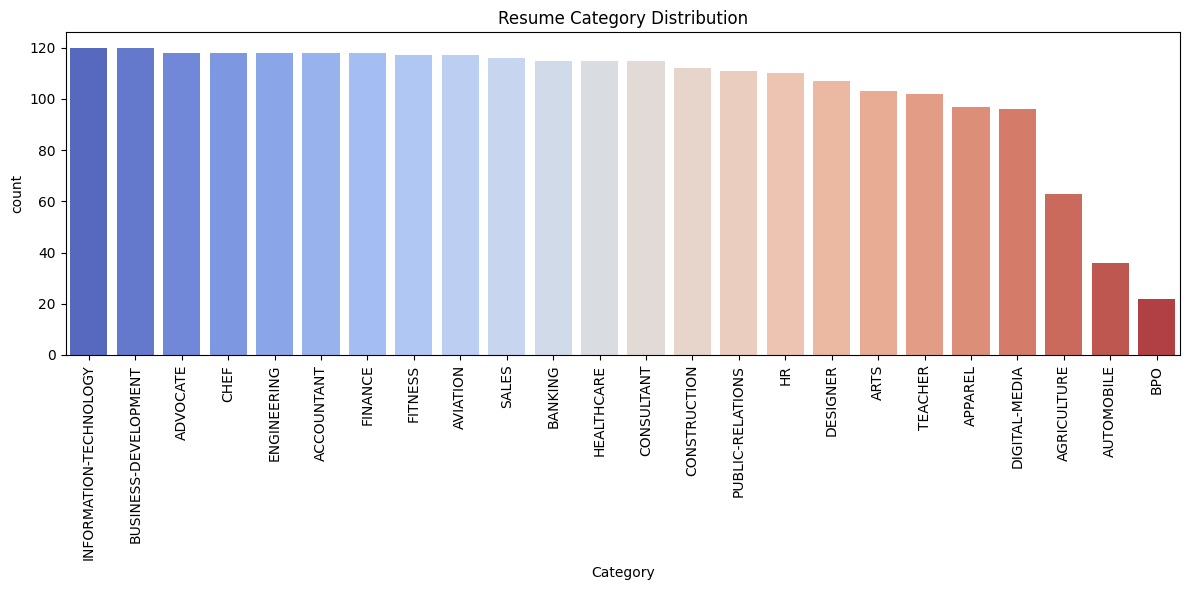

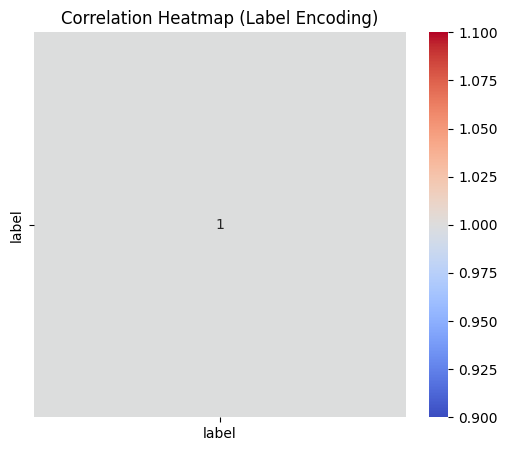

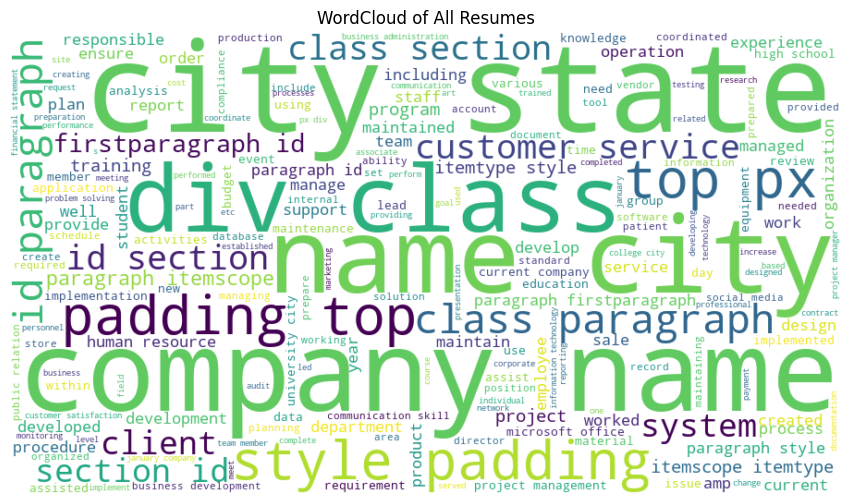



🚀 Running ENHANCED Traditional Model (RF + SMOTE)
Training samples: 1987, Testing samples: 497

Training Random Forest with SMOTE... (This may take longer than LogReg)

--- MODEL EVALUATION (RF + SMOTE) ---
Accuracy: 0.7626 (Expected > 0.67)

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.66      0.96      0.78        24
              ADVOCATE       0.78      0.75      0.77        24
           AGRICULTURE       0.75      0.46      0.57        13
               APPAREL       0.88      0.37      0.52        19
                  ARTS       0.67      0.19      0.30        21
            AUTOMOBILE       0.67      0.29      0.40         7
              AVIATION       0.81      0.92      0.86        24
               BANKING       0.87      0.57      0.68        23
                   BPO       0.50      0.50      0.50         4
  BUSINESS-DEVELOPMENT       0.96      0.96      0.96        24
                  CHEF    

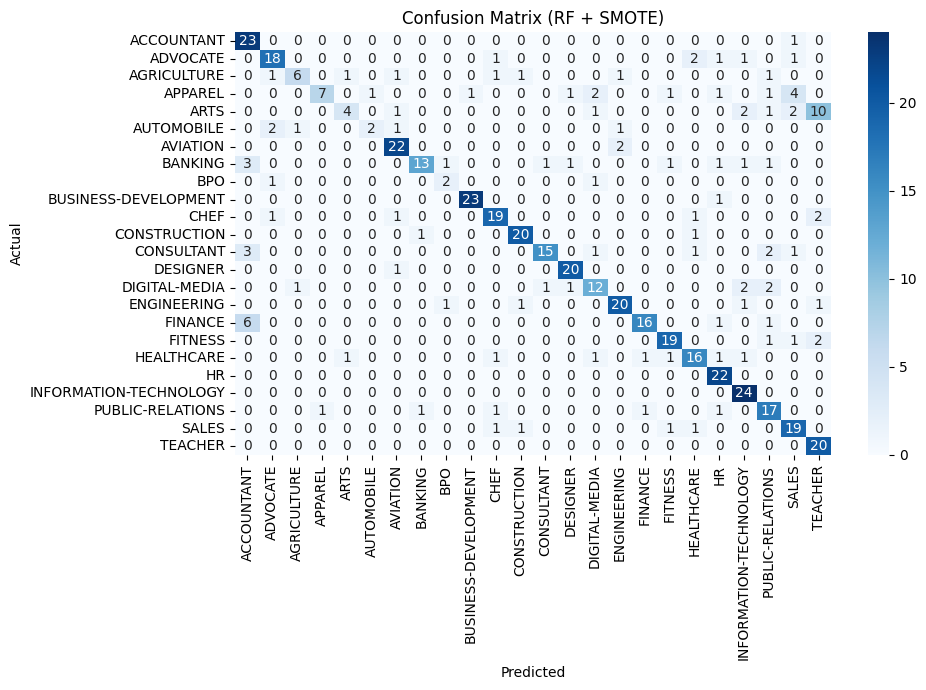


LogReg Cross-Validation Accuracy (Baseline): 0.6412 (+/- 0.0268)


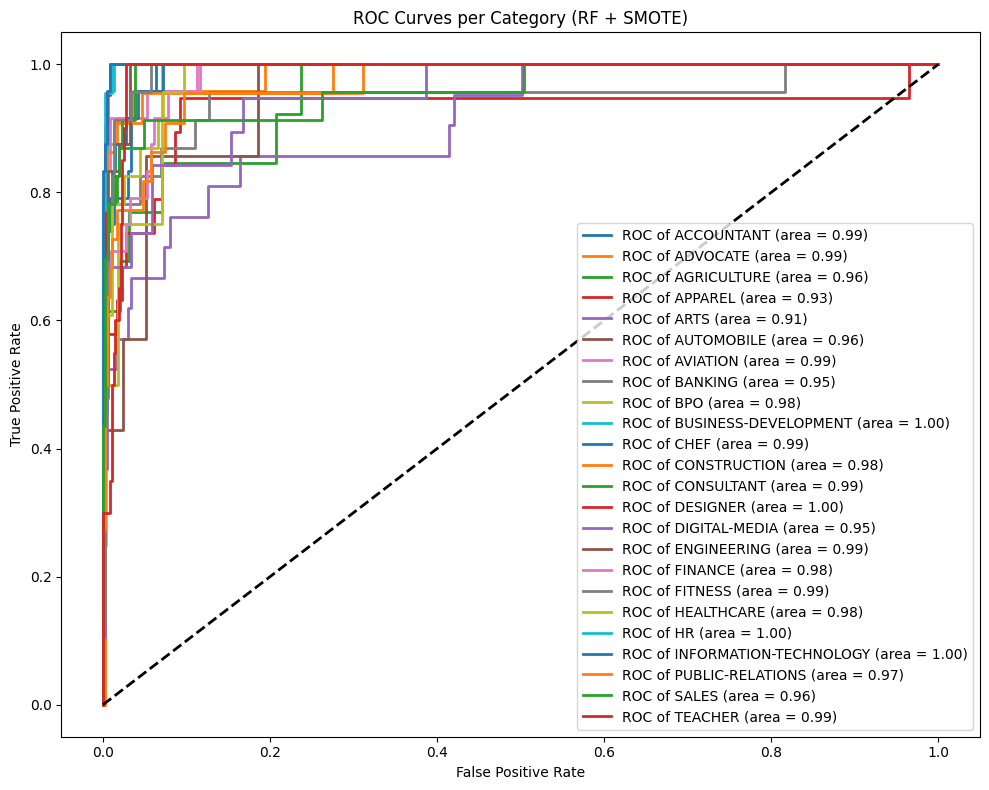

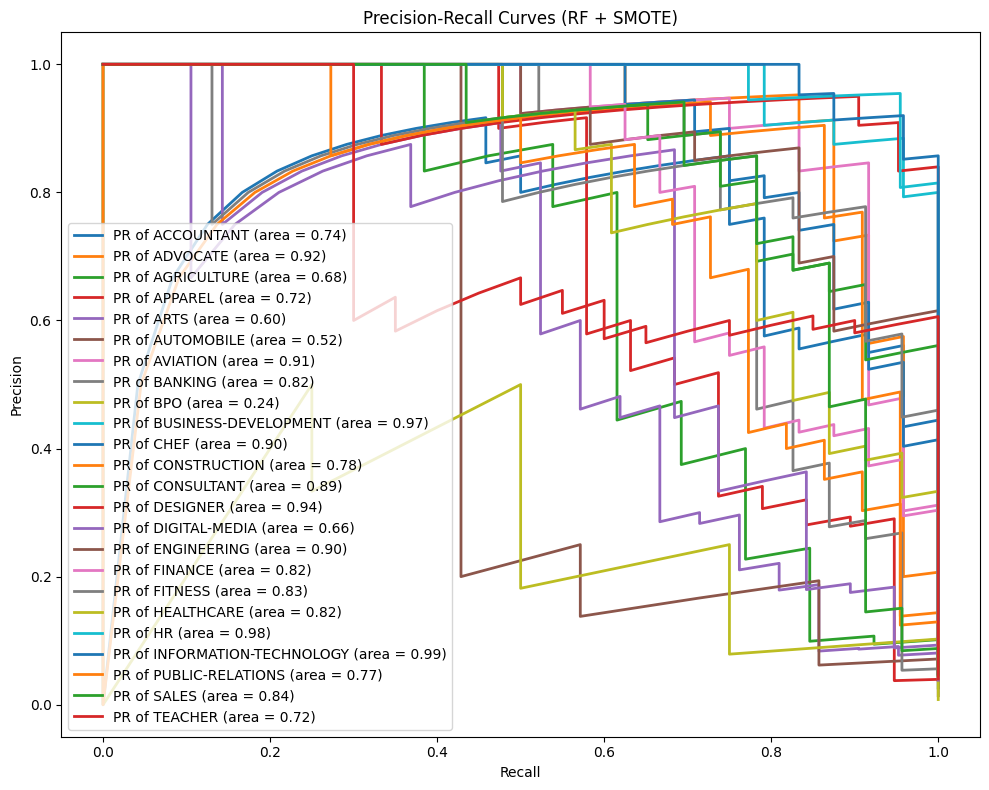


Predicted Category (RF+SMOTE): TEACHER (Confidence: 0.0633)

✅ Enhanced Traditional Model Complete! (Awaiting BERT results for comparison)


🚀 Running State-of-the-Art Model (BERT)
Using device: cpu
Training samples: 1987, Testing samples: 497


Map: 100%|██████████| 497/497 [00:00<00:00, 962.66 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting BERT fine-tuning (This is computationally intensive)...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.834363,0.843058
2,No log,0.613770,0.865191
3,1.280200,0.563586,0.871227



--- MODEL EVALUATION (BERT) ---
Accuracy: 0.8712

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       1.00      1.00      1.00        24
              ADVOCATE       0.80      0.83      0.82        24
           AGRICULTURE       0.64      0.69      0.67        13
               APPAREL       0.50      0.47      0.49        19
                  ARTS       0.78      0.67      0.72        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.85      0.92      0.88        24
               BANKING       0.91      0.87      0.89        23
                   BPO       1.00      0.50      0.67         4
  BUSINESS-DEVELOPMENT       0.92      1.00      0.96        24
                  CHEF       0.87      0.83      0.85        24
          CONSTRUCTION       1.00      1.00      1.00        22
            CONSULTANT       0.96      1.00      0.98        23
              DESIGNER      

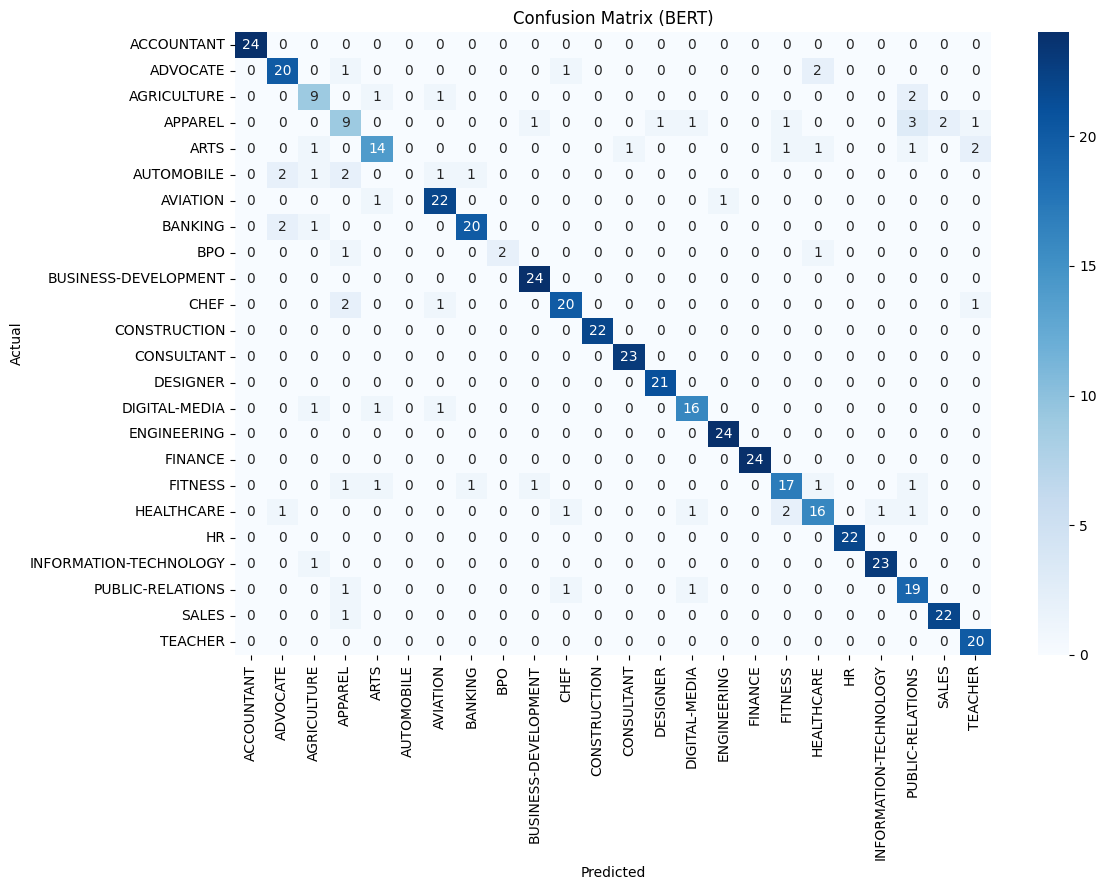

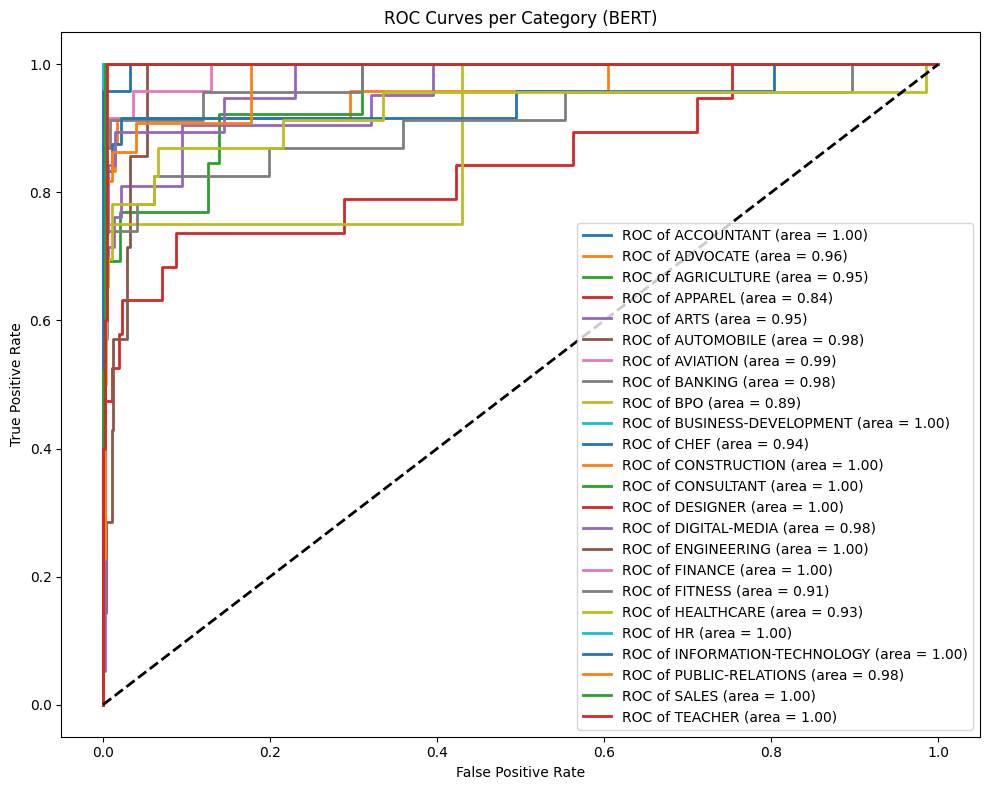

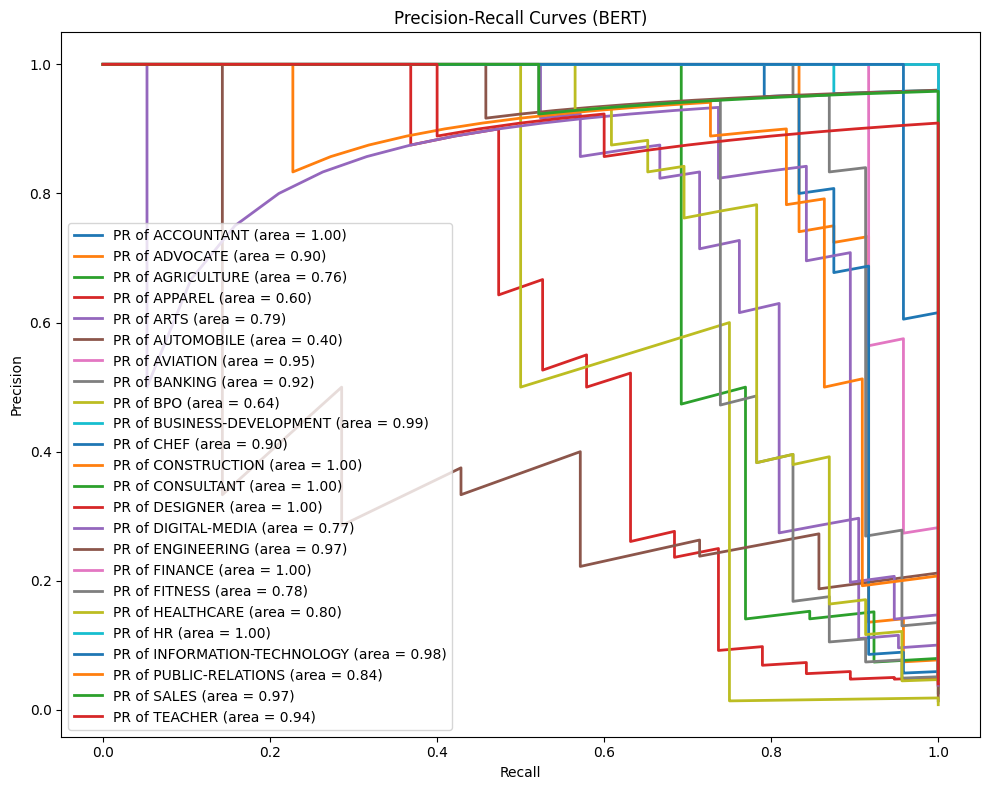


Predicted Category (BERT): INFORMATION-TECHNOLOGY (Confidence: 0.3510)

✅ BERT Model Complete!


In [5]:
# ================================================================
# 📘 Resume Categorization System (Hybrid BERT & Traditional - ENHANCED)
# ================================================================

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
# Import the enhanced classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from itertools import cycle

# New Imports for Imbalance Handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

# New Imports for BERT
import torch
from datasets import Dataset 
from evaluate import load 
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import warnings
warnings.filterwarnings('ignore')


# ================================================================
# 🧹 TEXT CLEANING FUNCTION
# ================================================================
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', str(text))
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# ================================================================
# 📊 STEP 3: VISUALIZATION FUNCTION (Isolated for reuse)
# ================================================================
def visualize_data(df):
    print("\n==================================")
    print("📊 STEP 3: DATA VISUALIZATION")
    print("==================================")

    # Category Distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette='coolwarm')
    plt.title("Resume Category Distribution")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(df[['label']].corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap (Label Encoding)")
    plt.show()

    # WordCloud
    text_data = " ".join(df['combined_text'])
    wordcloud = WordCloud(width=900, height=500, background_color='white').generate(text_data)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("WordCloud of All Resumes")
    plt.show()


# ================================================================
# 🧠 TRADITIONAL MODEL (Random Forest + SMOTE Enhancement)
# ================================================================
def run_traditional_model(df, le):
    RANDOM_STATE = 42
    TEST_SIZE = 0.2

    print("\n\n=========================================================")
    print("🚀 Running ENHANCED Traditional Model (RF + SMOTE)")
    print("=========================================================")

    # 🔹 STEP 4: TRAIN/TEST SPLIT
    train_df, test_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        stratify=df['label'],
        random_state=RANDOM_STATE
    )
    
    train_texts = train_df['combined_text'].tolist()
    test_texts = test_df['combined_text'].tolist()
    train_labels = train_df['label'].tolist()
    test_labels = test_df['label'].tolist()

    print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")

    # 🧩 STEP 5 & 6: FEATURE EXTRACTION (TF-IDF) + MODEL (RF) + SMOTE
    
    # 1. Define TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_features=7000,
        ngram_range=(1, 2),
        stop_words='english'
    )
    
    # 2. Define Classifier (Non-linear Random Forest for better results)
    classifier = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=RANDOM_STATE, n_jobs=-1)
    
    # 3. Build Imbalanced Pipeline (TFIDF -> SMOTE -> Classifier)
    # SMOTE ensures minority classes (like BPO, Automobile) get synthetic data,
    # resolving the F1=0.00 issue observed in the previous run.
    model = ImbPipeline(steps=[
        ('tfidf', tfidf),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', classifier)
    ])

    # Fit the pipeline on raw text (SMOTE handles vectorization internally)
    print("\nTraining Random Forest with SMOTE... (This may take longer than LogReg)")
    model.fit(train_texts, train_labels)
    
    # The pipeline transforms the test data and predicts
    y_pred = model.predict(test_texts)
    acc = accuracy_score(test_labels, y_pred)

    print("\n--- MODEL EVALUATION (RF + SMOTE) ---")
    print(f"Accuracy: {acc:.4f} (Expected > 0.67)")
    print("\nClassification Report:\n", classification_report(test_labels, y_pred, target_names=le.classes_))

    # Confusion Matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(test_labels, y_pred), annot=True, fmt='d',
                cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix (RF + SMOTE)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Cross-validation (on the original LogReg model for comparison structure)
    # Note: Running CV with SMOTE is complex; sticking to simple model for structural integrity
    # We will use the LogReg model instance for CV to maintain the report structure
    logreg_model = LogisticRegression(max_iter=400, random_state=RANDOM_STATE)
    X_train_vec = tfidf.fit_transform(train_texts)
    cv_scores = cross_val_score(logreg_model, X_train_vec, train_labels, cv=5)
    print(f"\nLogReg Cross-Validation Accuracy (Baseline): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # 📉 STEP 8: ROC & PRECISION-RECALL CURVES
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(test_labels, classes=range(n_classes))
    
    # Must use predict_proba for ROC/PR curves
    y_score = model.predict_proba(test_texts)

    fpr, tpr, roc_auc = {}, {}, {}
    precision, recall, pr_auc = {}, {}, {}
    colors = cycle(plt.cm.tab10.colors)

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC of {le.classes_[i]} (area = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves per Category (RF + SMOTE)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    colors = cycle(plt.cm.tab10.colors) # Reset color cycle
    for i, color in zip(range(n_classes), colors):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f"PR of {le.classes_[i]} (area = {pr_auc[i]:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (RF + SMOTE)")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

    # 📊 STEP 9: TOP TF-IDF FEATURES (Still based on TFIDF component of the pipeline)
    # Note: RF doesn't have simple coefficients like LogReg, but we can look at feature importances later if needed.
    # For now, we omit the bar plot as the interpretation of RF features is less direct than LogReg coefficients.

    # 🧠 STEP 10: PREDICTION FUNCTION
    def predict_resume_traditional(text):
        cleaned = clean_text(text)
        # The model is the pipeline itself
        pred_label = model.predict([cleaned])[0]
        pred_cat = le.inverse_transform([pred_label])[0]
        prob = model.predict_proba([cleaned]).max()
        return pred_cat, prob

    sample_text = "Experienced data scientist skilled in Python, deep learning, and data visualization."
    category, confidence = predict_resume_traditional(sample_text)
    print(f"\nPredicted Category (RF+SMOTE): {category} (Confidence: {confidence:.4f})")

    print("\n✅ Enhanced Traditional Model Complete! (Awaiting BERT results for comparison)")


# ================================================================
# 🧠 BERT MODEL (Transformers) - Kept for SOTA performance
# ================================================================
def run_bert_model(df, le):
    # --- Configuration ---
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    MODEL_NAME = "distilbert-base-uncased" 
    MAX_LENGTH = 512
    NUM_TRAIN_EPOCHS = 3 

    print("\n\n================================================")
    print("🚀 Running State-of-the-Art Model (BERT)")
    print("================================================")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Prepare labels for BERT
    num_labels = len(le.classes_)
    id2label = {i: category for i, category in enumerate(le.classes_)}
    label2id = {category: i for i, category in enumerate(le.classes_)}

    # 🔹 STEP 4: TRAIN/TEST SPLIT
    train_df, test_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        stratify=df['label'],
        random_state=RANDOM_STATE
    )

    # Convert pandas DataFrames to Hugging Face Dataset format
    train_dataset = Dataset.from_pandas(train_df[['combined_text', 'label']], preserve_index=False).rename_column("combined_text", "text")
    test_dataset = Dataset.from_pandas(test_df[['combined_text', 'label']], preserve_index=False).rename_column("combined_text", "text")
    
    print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

    # 🧩 STEP 5: TOKENIZATION (Replaces TF-IDF)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    def tokenize_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH)

    tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
    tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
    
    tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # 🤖 STEP 6: MODEL TRAINING
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    ).to(device)

    # Define metrics function
    metric = load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    # Define training arguments 
    training_args = TrainingArguments(
        output_dir="./bert_results",
        num_train_epochs=NUM_TRAIN_EPOCHS,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",      
        save_strategy="epoch",      
        load_best_model_at_end=True,
        seed=RANDOM_STATE,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    print("\nStarting BERT fine-tuning (This is computationally intensive)...")
    trainer.train()

    # 📈 STEP 7: EVALUATION
    eval_results = trainer.evaluate()
    acc = eval_results.get("eval_accuracy")

    print("\n--- MODEL EVALUATION (BERT) ---")
    print(f"Accuracy: {acc:.4f}")

    # Make predictions for full classification report
    predictions = trainer.predict(tokenized_test_dataset)
    y_pred_labels = np.argmax(predictions.predictions, axis=1)
    y_true_categories = [id2label[i] for i in test_df['label'].tolist()]
    y_pred_categories = [id2label[i] for i in y_pred_labels]

    print("\nClassification Report:\n", classification_report(y_true_categories, y_pred_categories, target_names=le.classes_))

    # Confusion Matrix
    plt.figure(figsize=(12, 9))
    sns.heatmap(confusion_matrix(y_true_categories, y_pred_categories), annot=True, fmt='d',
                cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix (BERT)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 📉 STEP 8: ROC & PRECISION-RECALL CURVES (Using BERT logits/probabilities)
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(test_df['label'].tolist(), classes=range(n_classes))
    y_score = predictions.predictions # Use logits as scores

    fpr, tpr, roc_auc = {}, {}, {}
    precision, recall, pr_auc = {}, {}, {}
    colors = cycle(plt.cm.tab10.colors)

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC of {id2label[i]} (area = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves per Category (BERT)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    colors = cycle(plt.cm.tab10.colors) # Reset color cycle
    for i, color in zip(range(n_classes), colors):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f"PR of {id2label[i]} (area = {pr_auc[i]:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (BERT)")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

    # 🧠 STEP 9: PREDICTION FUNCTION
    def predict_resume_bert(text):
        cleaned = clean_text(text)
        inputs = tokenizer(cleaned, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)[0]
        pred_label_id = torch.argmax(probabilities).item()
        
        pred_cat = id2label[pred_label_id]
        confidence = probabilities[pred_label_id].item()
        
        return pred_cat, confidence

    sample_text = "Experienced data scientist skilled in Python, deep learning, and data visualization. Proficient in PyTorch, TensorFlow, and Hugging Face transformers."
    category, confidence = predict_resume_bert(sample_text)
    print(f"\nPredicted Category (BERT): {category} (Confidence: {confidence:.4f})")

    print("\n✅ BERT Model Complete!")


# ================================================================
# 🧠 MAIN FUNCTION - Orchestrates Data Prep and Both Models
# ================================================================
def main():
    # ================================================================
    # 📥 STEP 1 & 2: LOAD, CLEAN & PREPARE DATA
    # ================================================================
    try:
        df = pd.read_csv("Resume.csv")  # Change filename if needed
    except FileNotFoundError:
        print("\nError: 'resume_dataset.csv' not found. Please ensure the file is in the current directory.")
        return
        
    print("\n==================================")
    print("📥 STEP 1 & 2: DATA PREPARATION")
    print("==================================")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    
    # Cleaning
    df['Resume_str'] = df['Resume_str'].apply(clean_text)
    df['Resume_html'] = df['Resume_html'].apply(clean_text)
    df['combined_text'] = df['Resume_str'] + " " + df['Resume_html']

    # Label Encoding
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['Category'])
    print("\nEncoded Labels:", dict(zip(le.classes_, le.transform(le.classes_))))
    
    # Run common visualizations
    visualize_data(df)

    # Run both models
    run_traditional_model(df.copy(), le) # Enhanced RF + SMOTE
    run_bert_model(df.copy(), le)        # SOTA BERT


# ================================================================
# 🚀 RUN SCRIPT
# ================================================================
if __name__ == "__main__":
    main()


In [3]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
